In [1]:
library(mgcv)

Loading required package: nlme
This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.


In [2]:
DATA_DIR <- '../../data/Xy_internal_split_data'

In [3]:
merge.files <- function(set=c('train', 'valid', 'test')) {
  cat(sprintf('Merging %s data...\n', set))
  all.files <- list.files(DATA_DIR)
  X.files <- sort(all.files[grepl(paste('X', set, sep='_'), all.files)])
  y.files <- sort(all.files[grepl(paste('y', set, sep='_'), all.files)])
  X <- read.csv(paste(DATA_DIR, X.files[1], sep='/'))
  y <- read.csv(paste(DATA_DIR, y.files[1], sep='/'))
  data <- cbind(y, X)
  if (length(X.files) > 1) {
    for (i in 2:length(X.files)) {
      next.X <- read.csv(paste(DATA_DIR, X.files[i], sep='/'))
      next.y <- read.csv(paste(DATA_DIR, y.files[i], sep='/'))
      next.data <- cbind(next.y, next.X)
      data <- rbind(data, next.data)
    }
  }
  data
}

In [4]:
train <- merge.files('train')

Merging train data...


In [5]:
head(train)

btl_t x  y  lon       lat      etopo1 btl_t1 btl_t2 vgt age       ⋯ TOctSep 
1 0     40 76 -118.6044 35.19896 1462   0      0      1    52.00000 ⋯ 12.16669
2 0     41 76 -118.4973 35.22012 1168   0      0      1    93.00145 ⋯ 15.03048
3 0     42 76 -118.3902 35.24117 1448   0      0      1   127.00000 ⋯ 13.71005
4 0     43 76 -118.2830 35.26209 1303   0      0      1     0.00000 ⋯ 14.17236
5 0     44 76 -118.1758 35.28289 1117   0      0      1     0.00000 ⋯ 15.29692
6 0     45 76 -118.0685 35.30357 1104   0      0      1     0.00000 ⋯ 16.23473
  summerP1   summerP2 Pmean    POctSep   PcumOctSep PPT      ddAugJul ddAugJun
1 14.8549149 49.56363 30.25321 188.66770 559.1683   2132.454 3322.514 2666.045
2  0.9030867 21.07341 26.08175 121.02350 439.2231   1778.957 4557.032 3838.315
3  3.7745873 32.79112 27.32411 122.42457 457.7471   1841.681 3992.136 3301.788
4  1.6001437 30.96236 26.97102 101.14716 430.7004   1767.129 4184.553 3482.938
5  0.6782972 26.93288 23.96723  71.82086 364.5691   1546.850 4630.234 3890.486
6  0.0000000 21.94927 20.39812  50.66428 299.9138   1309.458 5026.051 4245.324
  year
1 2003
2 2003
3 2003
4 2003
5 2003
6 2003

In [6]:
for (j in 1:ncol(train)) {
  cat(sprintf('%11s: %s (%d)\n', 
              names(train)[j], 
              class(train[, j]), 
              length(unique(train[, j]))))
}

      btl_t: integer (2)
          x: integer (129)
          y: integer (245)
        lon: numeric (31457)
        lat: numeric (31457)
     etopo1: integer (3256)
     btl_t1: integer (2)
     btl_t2: integer (2)
        vgt: integer (2)
        age: numeric (9739)
    density: numeric (26897)
    sum9_t1: integer (10)
    sum9_t2: integer (10)
    JanTmin: numeric (62900)
    MarTmin: numeric (62900)
    TMarAug: numeric (62913)
summerTmean: numeric (62914)
   AugTmean: numeric (62910)
    AugTmax: numeric (62903)
        GSP: numeric (62914)
    PMarAug: numeric (62914)
   summerP0: numeric (62887)
    OctTmin: numeric (62904)
  fallTmean: numeric (62911)
 winterTmin: numeric (62824)
       Tmin: numeric (62913)
      Tmean: numeric (62914)
       Tvar: numeric (62914)
    TOctSep: numeric (62913)
   summerP1: numeric (61798)
   summerP2: numeric (62914)
      Pmean: numeric (62914)
    POctSep: numeric (62889)
 PcumOctSep: numeric (62914)
        PPT: numeric (62914)
   ddAugJul: 

In [7]:
ignore <- c('btl_t', 'btl_t1', 'btl_t2', 'vgt', 'year', 'x', 'y')
numeric.preds <- names(train)[which(!(names(train) %in% ignore))]
for (p in numeric.preds) {
  cat(sprintf('s(%s) + ', p))
}

s(lon) + s(lat) + s(etopo1) + s(age) + s(density) + s(sum9_t1) + s(sum9_t2) + s(JanTmin) + s(MarTmin) + s(TMarAug) + s(summerTmean) + s(AugTmean) + s(AugTmax) + s(GSP) + s(PMarAug) + s(summerP0) + s(OctTmin) + s(fallTmean) + s(winterTmin) + s(Tmin) + s(Tmean) + s(Tvar) + s(TOctSep) + s(summerP1) + s(summerP2) + s(Pmean) + s(POctSep) + s(PcumOctSep) + s(PPT) + s(ddAugJul) + s(ddAugJun) + 

In [8]:
dim(train)

[1] 62914    38

In [11]:
gam.sample <- function(n.sample) {
  start <- Sys.time()
  gam.mod <- gam(
    btl_t ~ s(lon) + s(lat) + s(etopo1) + s(age) + s(density) + s(sum9_t1)
      + s(sum9_t2) + s(JanTmin) + s(MarTmin) + s(TMarAug) + s(summerTmean)
      + s(AugTmean) + s(AugTmax) + s(GSP) + s(PMarAug) + s(summerP0) 
      + s(OctTmin) + s(fallTmean) + s(winterTmin) + s(Tmin) + s(Tmean) 
      + s(Tvar) + s(TOctSep) + s(summerP1) + s(summerP2) + s(Pmean) 
      + s(POctSep) + s(PcumOctSep) + s(PPT) + s(ddAugJul) + s(ddAugJun),
    data=train[sample(nrow(train), n.sample), ],
    family='binomial')
  stop <- Sys.time()
  cat('Elapsed time:', stop - start, 's\n')
  gam.mod
}


Elapsed time: 1.669535 s


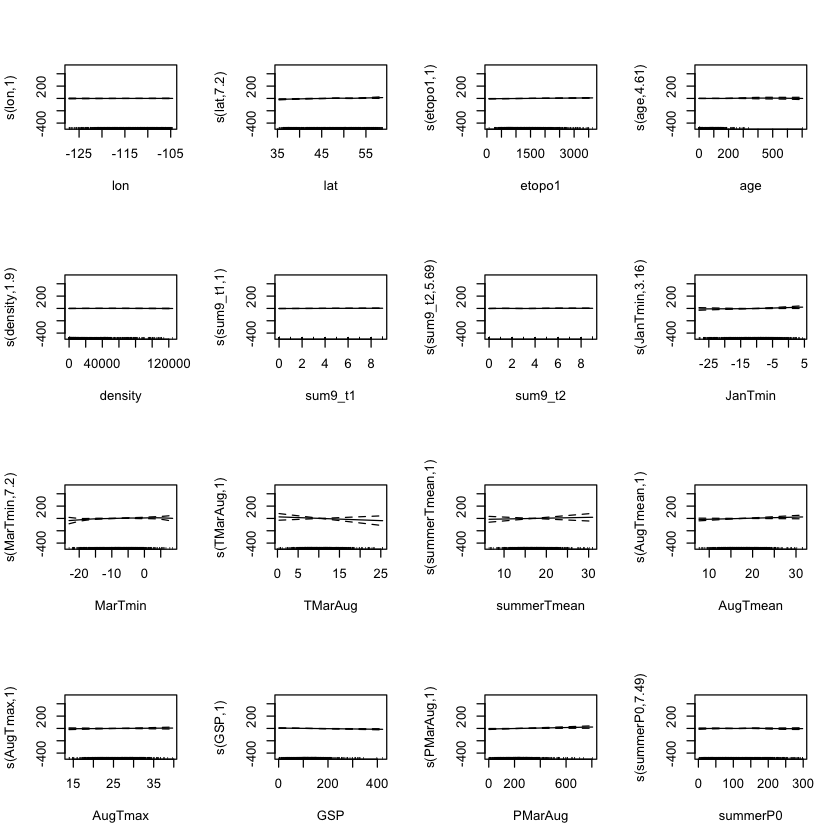

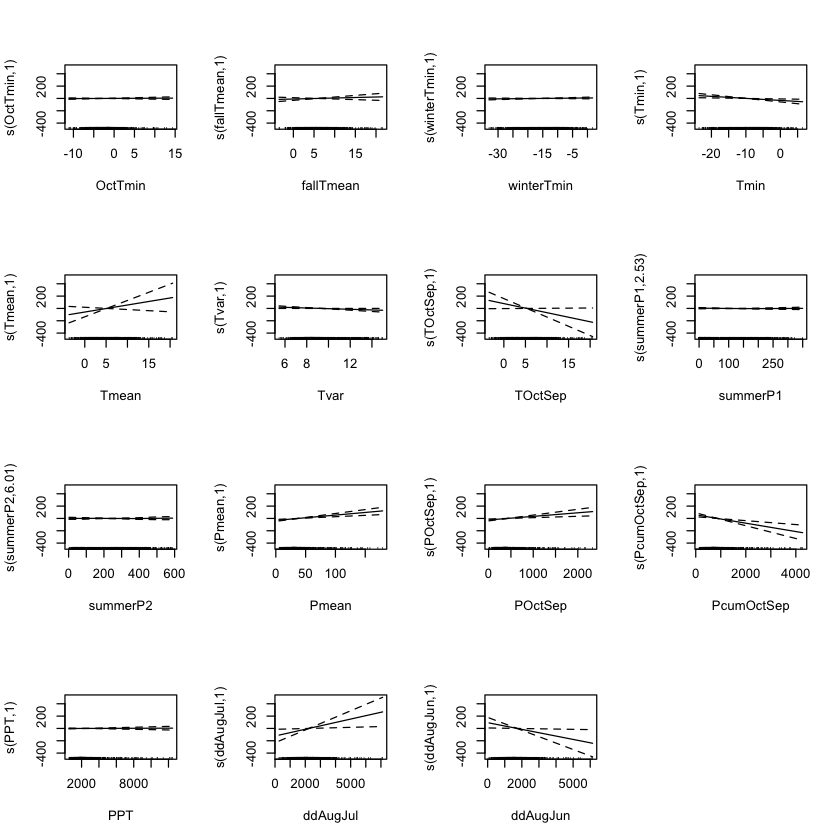

In [31]:
mod <- gam.sample(900)
par(mfrow=c(4, 4))
plot(mod)

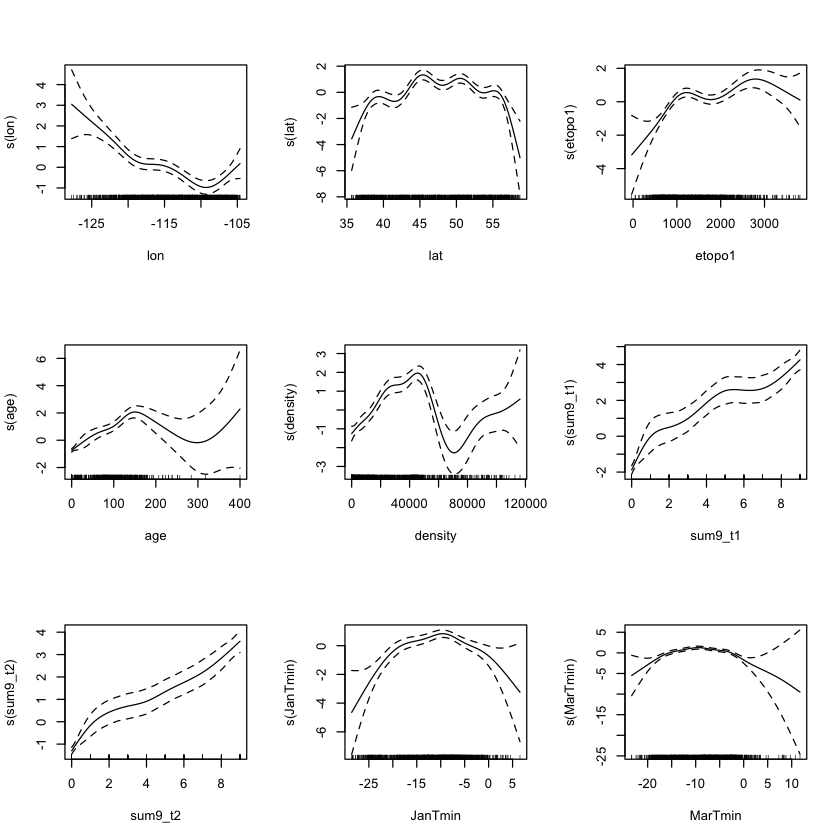

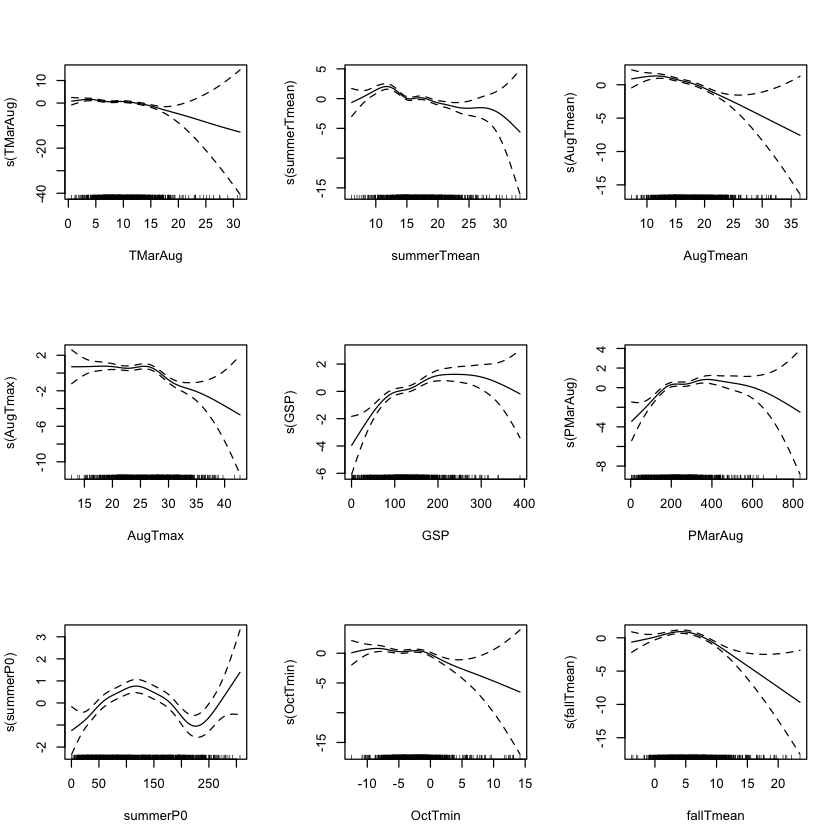

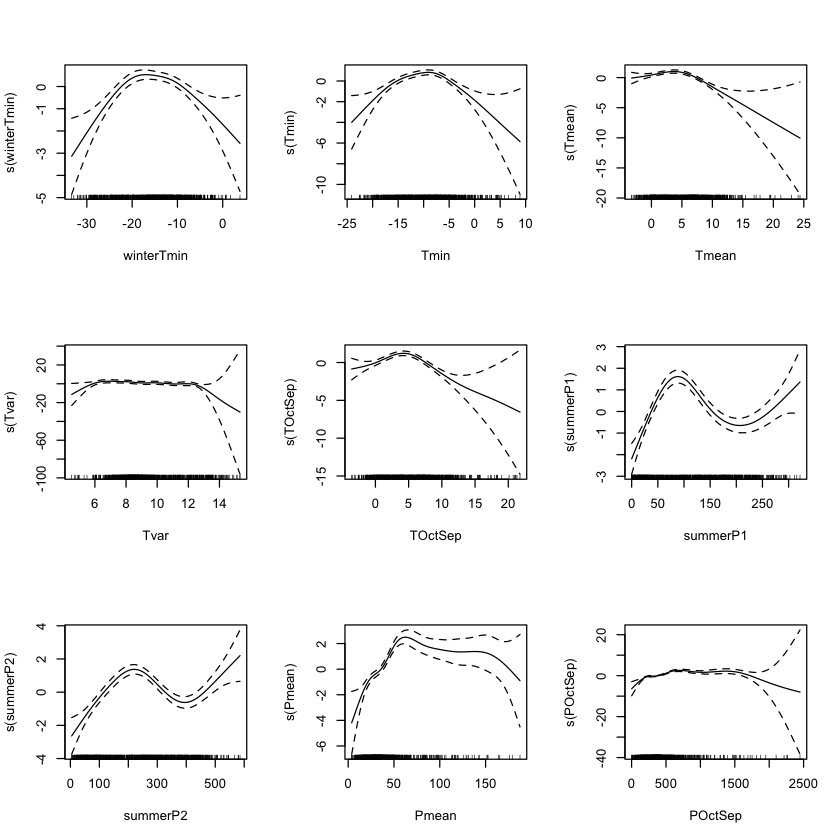

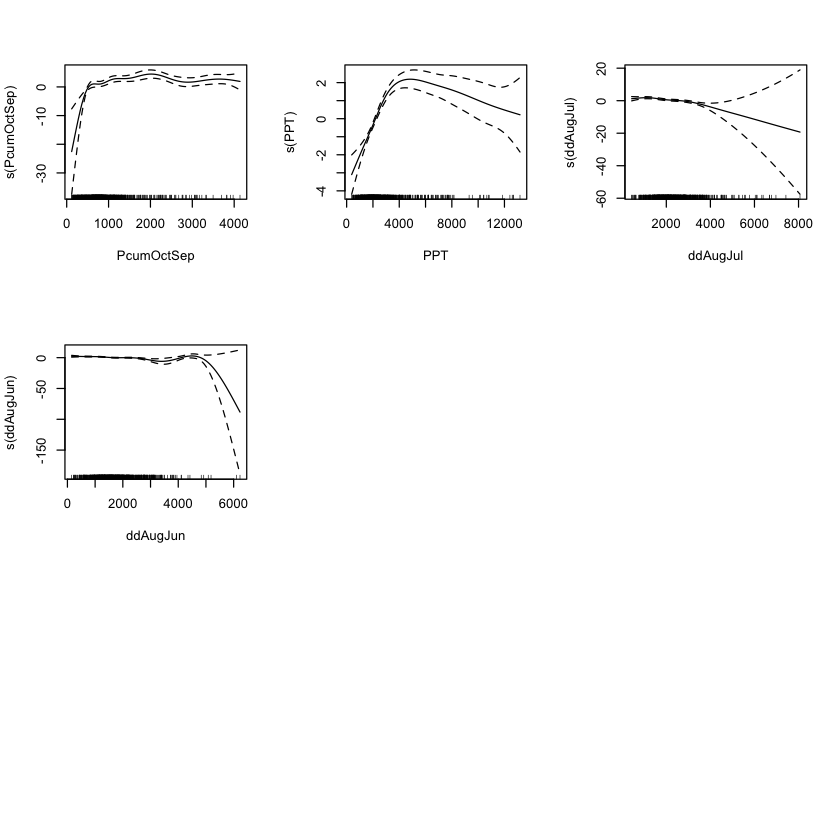

In [14]:
par(mfrow=c(3, 3))
for (field in names(train)) {
  if (!(field %in% ignore)) {
    n <- 1000
    s <- sample(nrow(train), n)
    gam.mod <- gam(train$btl_t[s] ~ s(train[s, field]), family='binomial')
    plot(gam.mod, xlab=field, ylab=paste('s(', field, ')', sep=''))    
  }
}

In [15]:
names(train)

[1] "btl_t"       "x"           "y"           "lon"         "lat"        
 [6] "etopo1"      "btl_t1"      "btl_t2"      "vgt"         "age"        
[11] "density"     "sum9_t1"     "sum9_t2"     "JanTmin"     "MarTmin"    
[16] "TMarAug"     "summerTmean" "AugTmean"    "AugTmax"     "GSP"        
[21] "PMarAug"     "summerP0"    "OctTmin"     "fallTmean"   "winterTmin" 
[26] "Tmin"        "Tmean"       "Tvar"        "TOctSep"     "summerP1"   
[31] "summerP2"    "Pmean"       "POctSep"     "PcumOctSep"  "PPT"        
[36] "ddAugJul"    "ddAugJun"    "year"

In [16]:
out <- data.frame(f1=c(), f2=c(), p=c())
options(warn=-1)

for (f1 in 4:(ncol(train) - 2)) {
  for (f2 in (f1 + 1):(ncol(train) - 1)) {
    mod <- glm(train$btl_t ~ train[, f1]*train[, f2], family='binomial')
    interaction.p <- summary(mod)$coef[4, 4]
    if (interaction.p < 0.001) {
      row <- data.frame(
          f1=names(train)[f1], f2=names(train)[f2], p=interaction.p) 
      out <- rbind(out, row)
    }
  }
}

options(warn=0)

In [17]:
interactions <- out[order(out$p), ]
dim(interactions)

[1] 513   3

In [18]:
head(interactions)

f1  f2      p
1  lon lat     0
2  lon etopo1  0
10 lon JanTmin 0
16 lon GSP     0
24 lon Tvar    0
28 lon Pmean   0

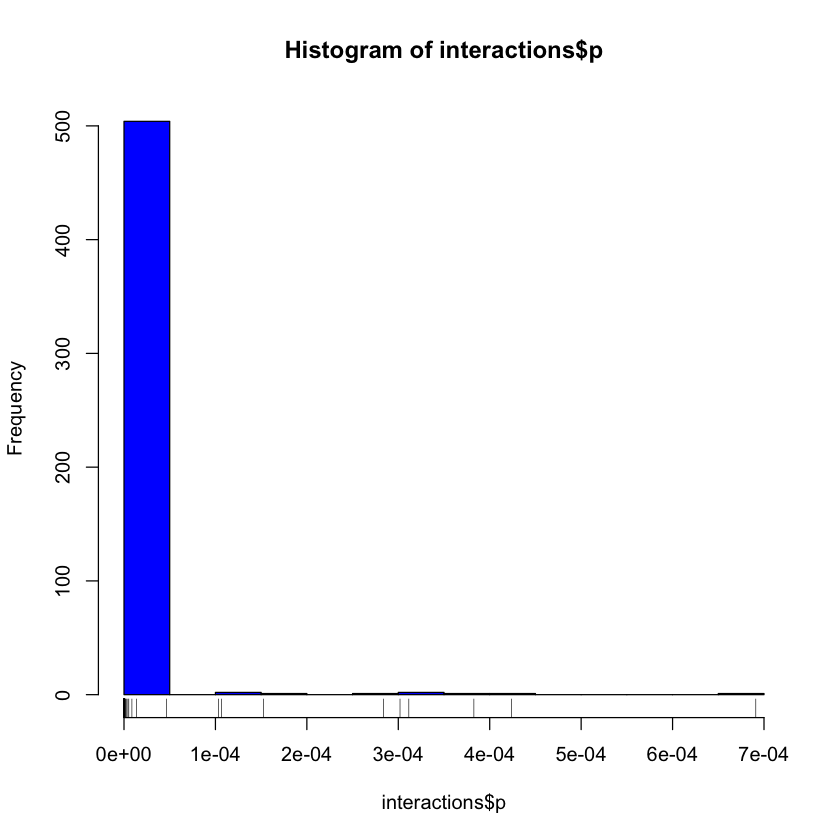

In [19]:
hist(interactions$p, col=4)
rug(interactions$p)

In [20]:
most.important <- interactions[interactions$p == 0, ]
dim(most.important)

[1] 160   3

In [21]:
head(most.important, 10)

f1  f2         p
1  lon lat        0
2  lon etopo1     0
10 lon JanTmin    0
16 lon GSP        0
24 lon Tvar       0
28 lon Pmean      0
29 lon POctSep    0
30 lon PcumOctSep 0
31 lon PPT        0
34 lat etopo1     0

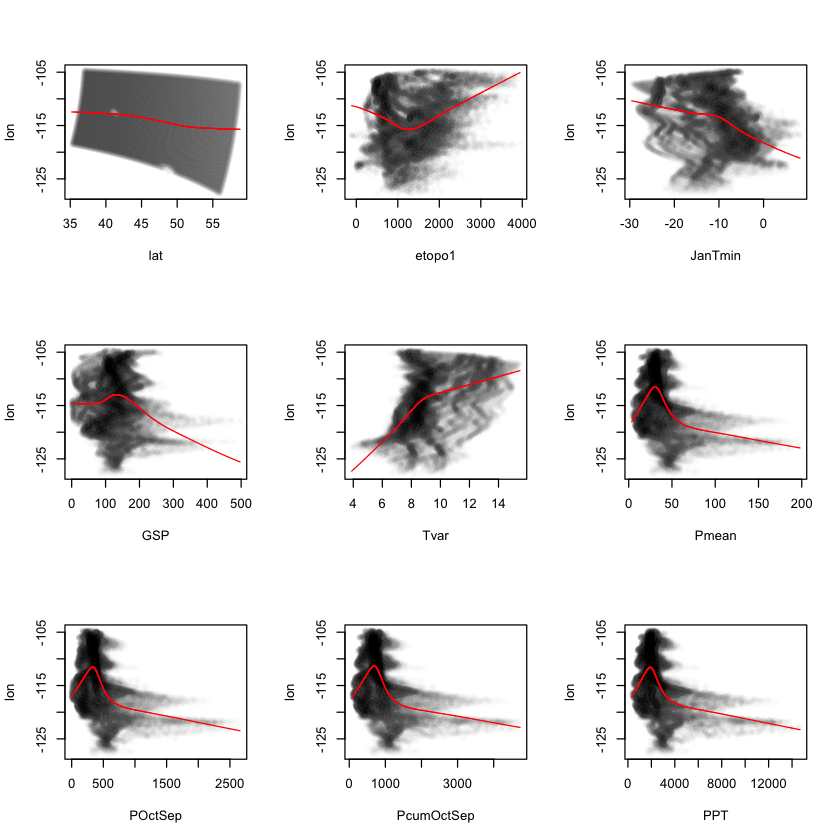

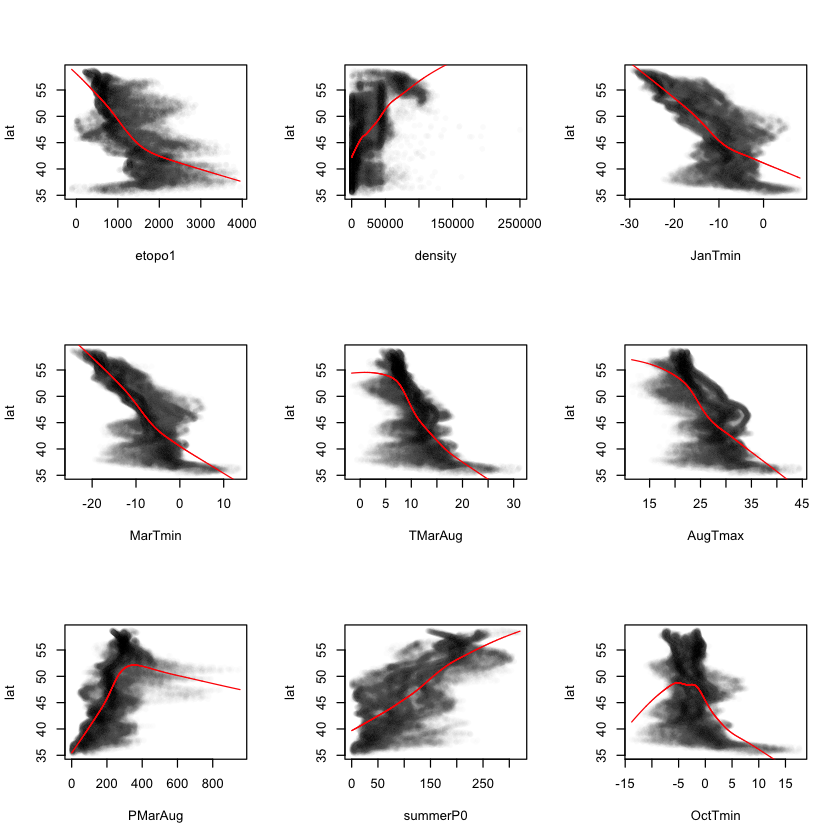

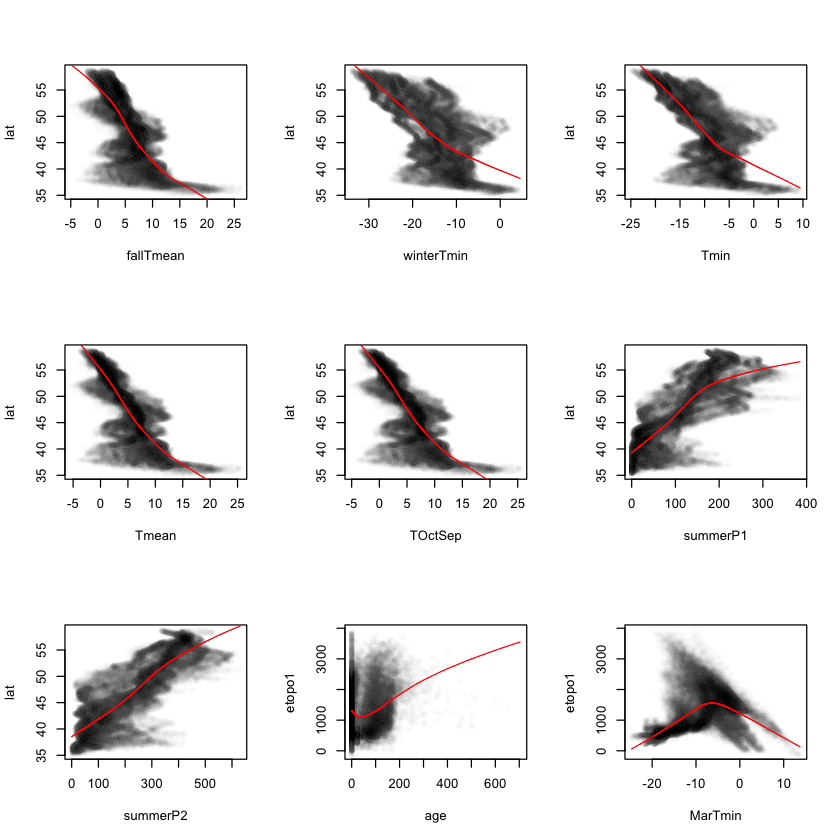

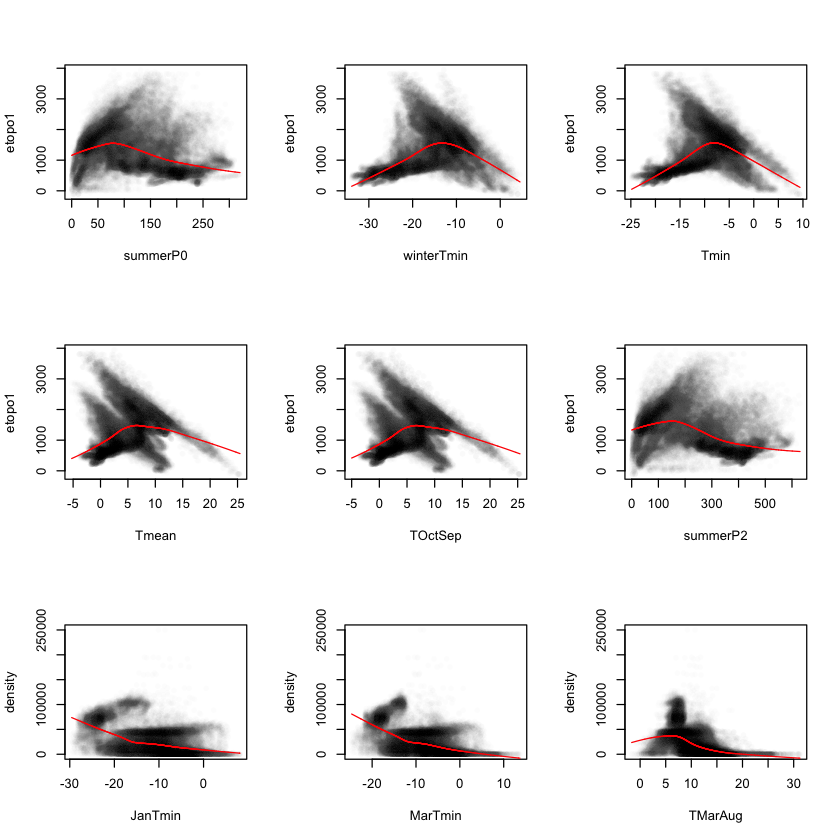

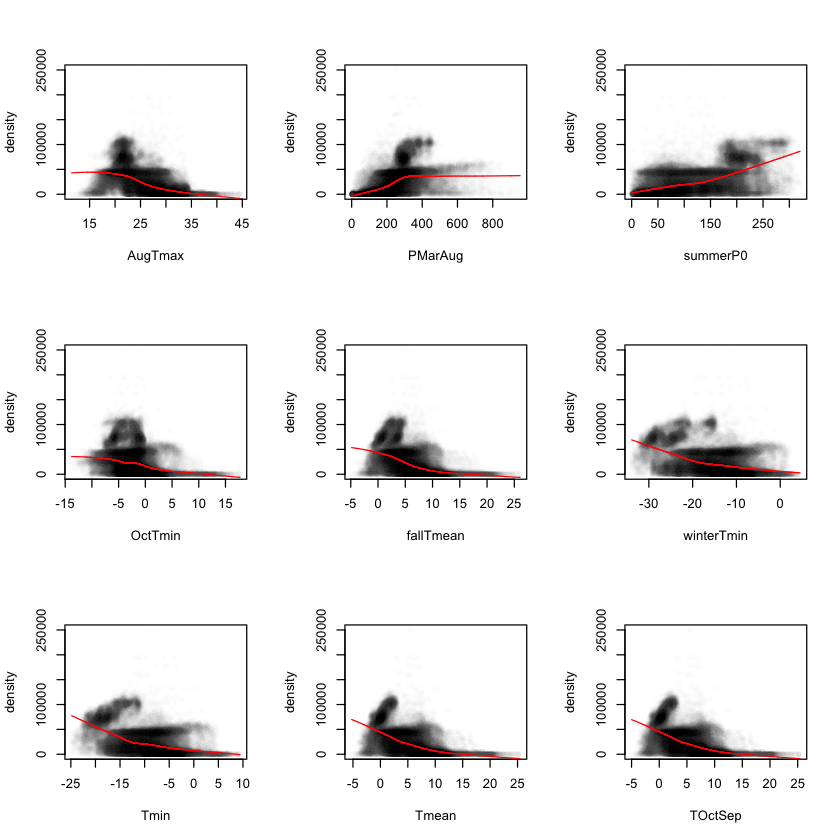

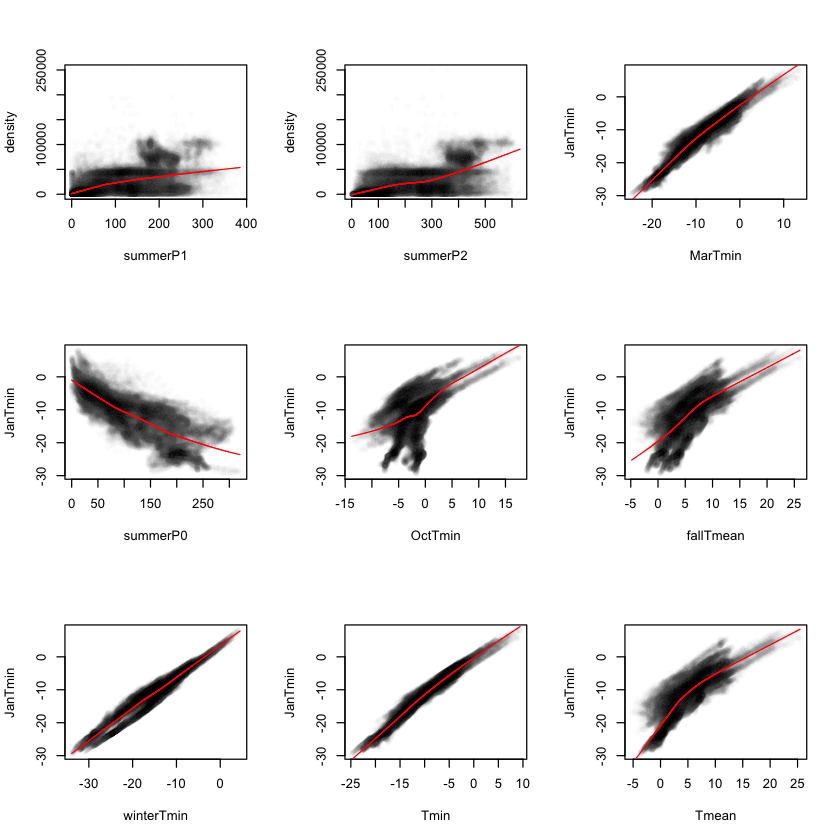

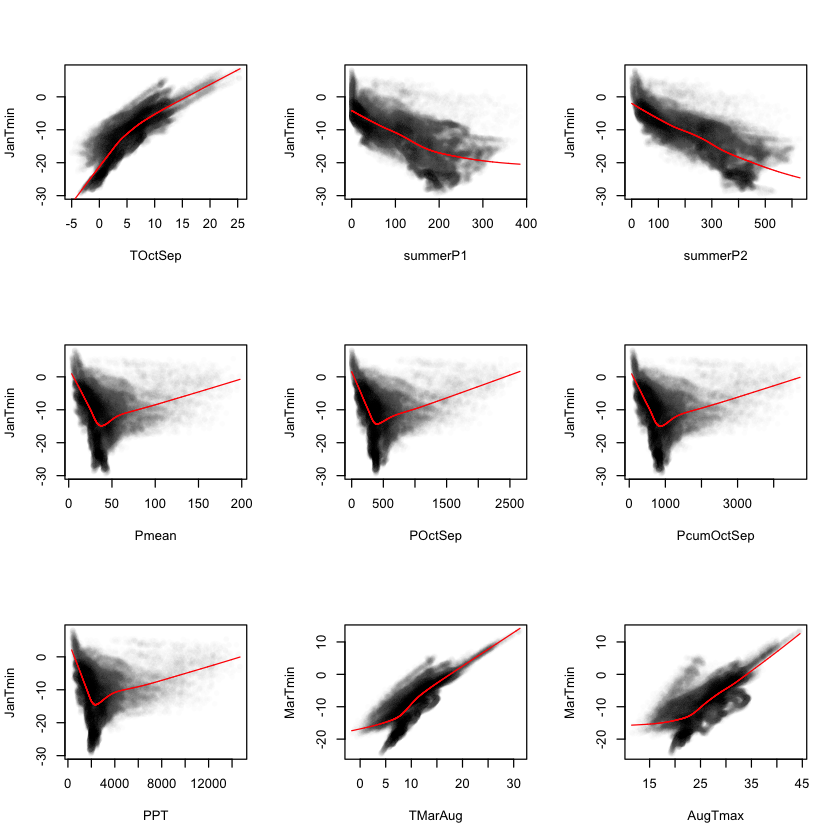

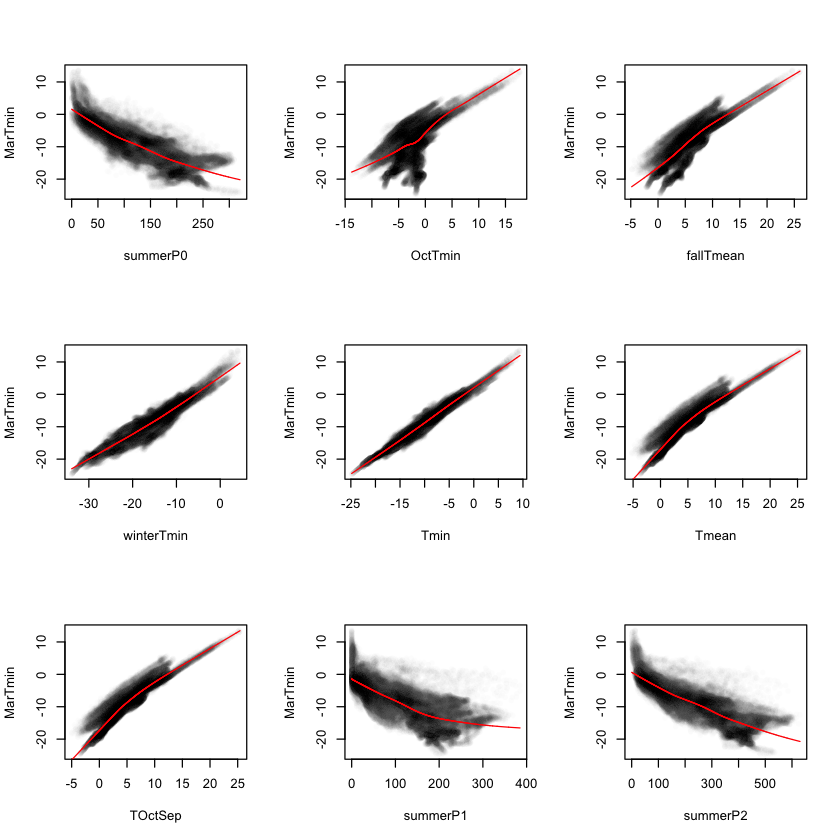

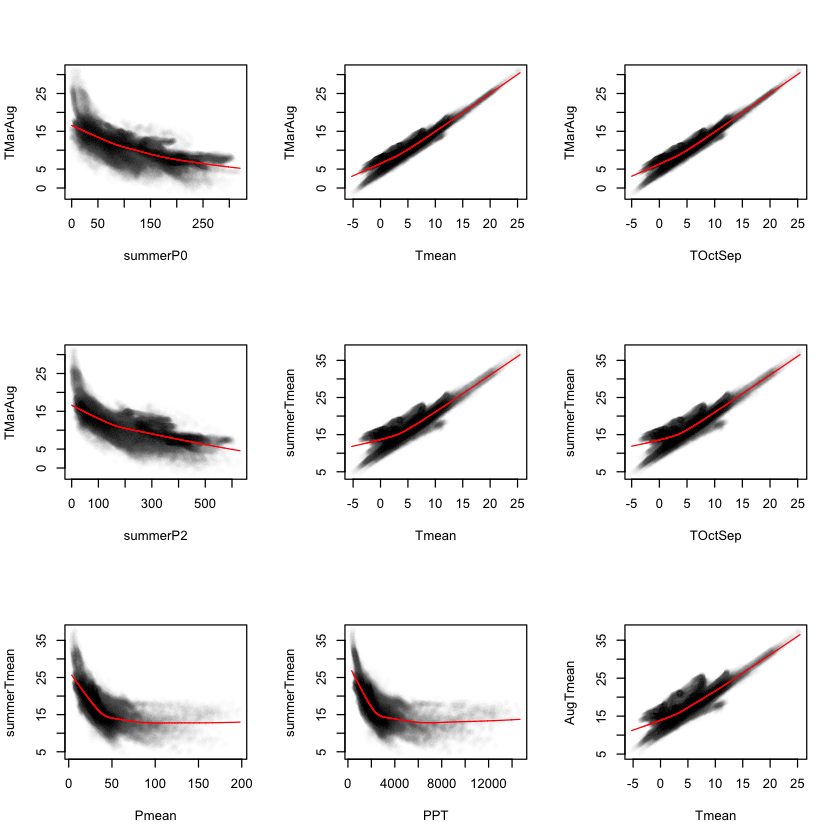

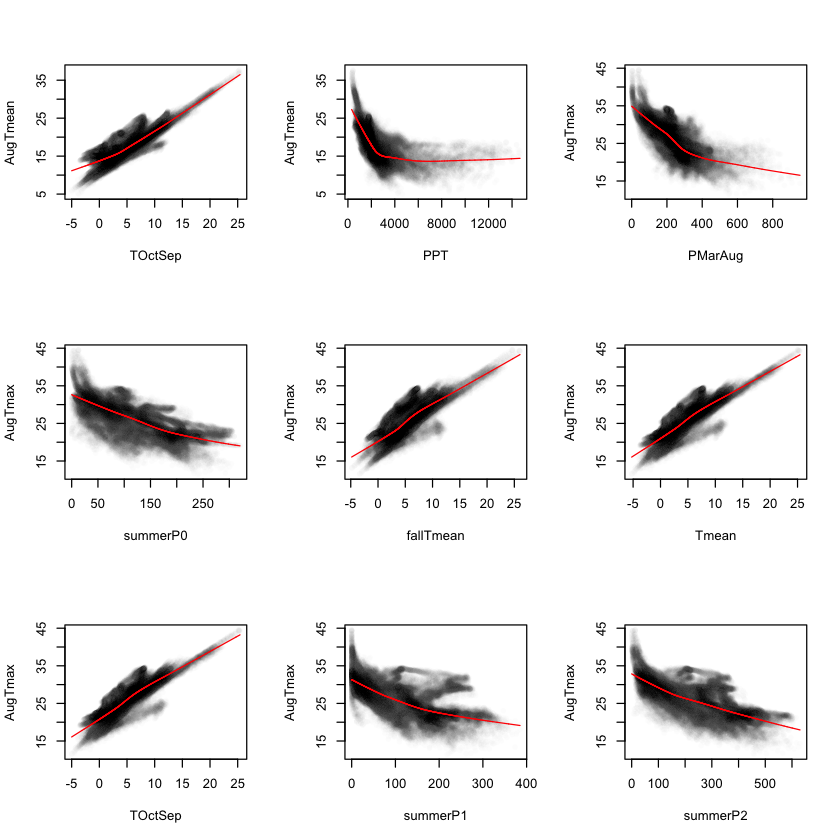

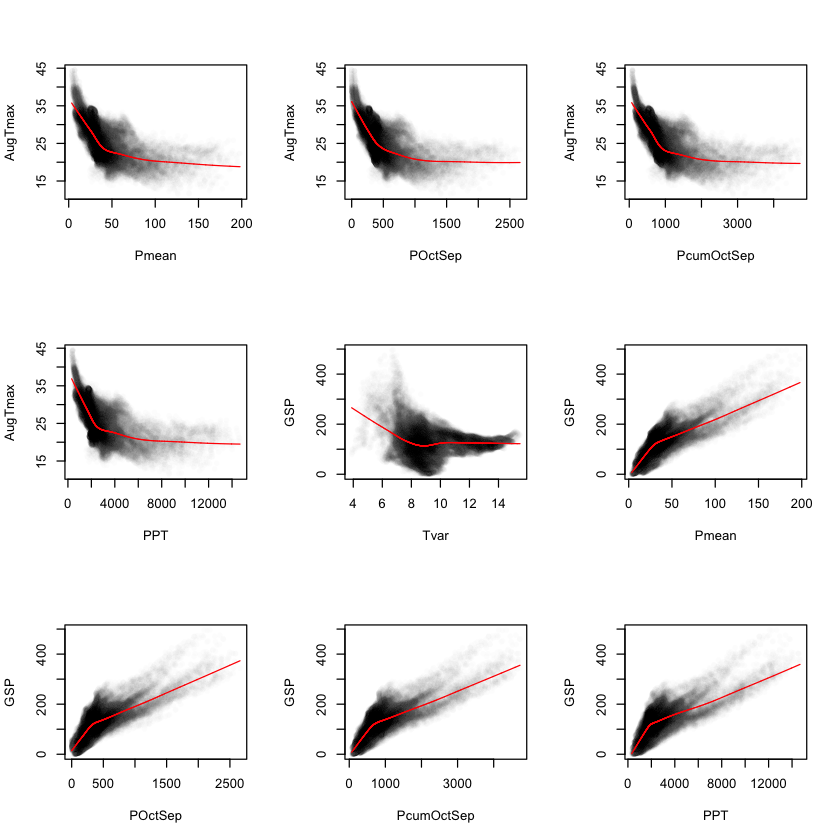

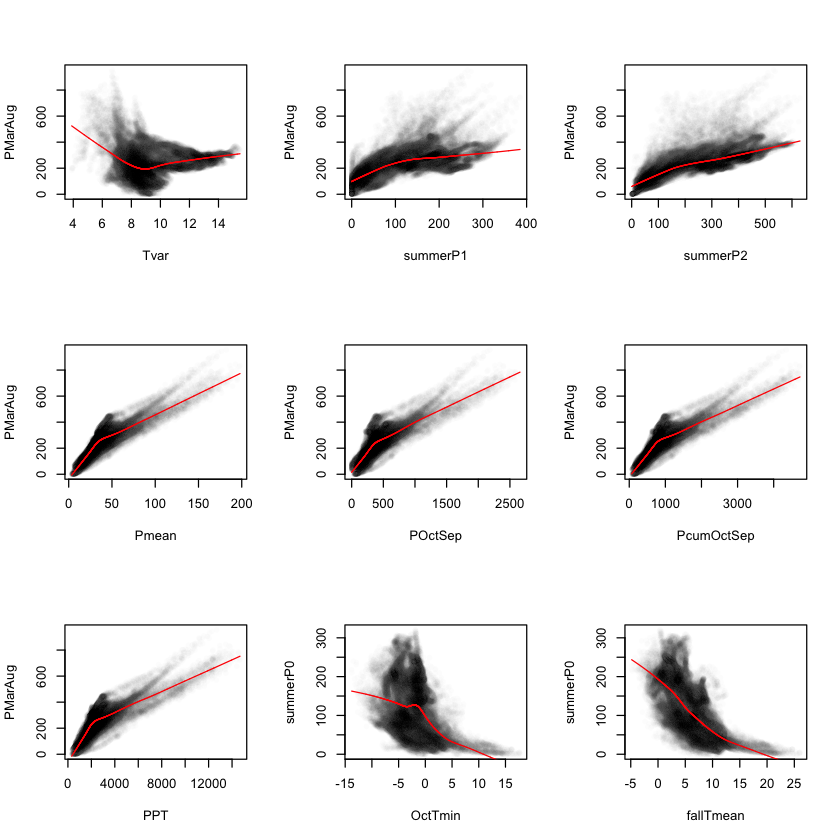

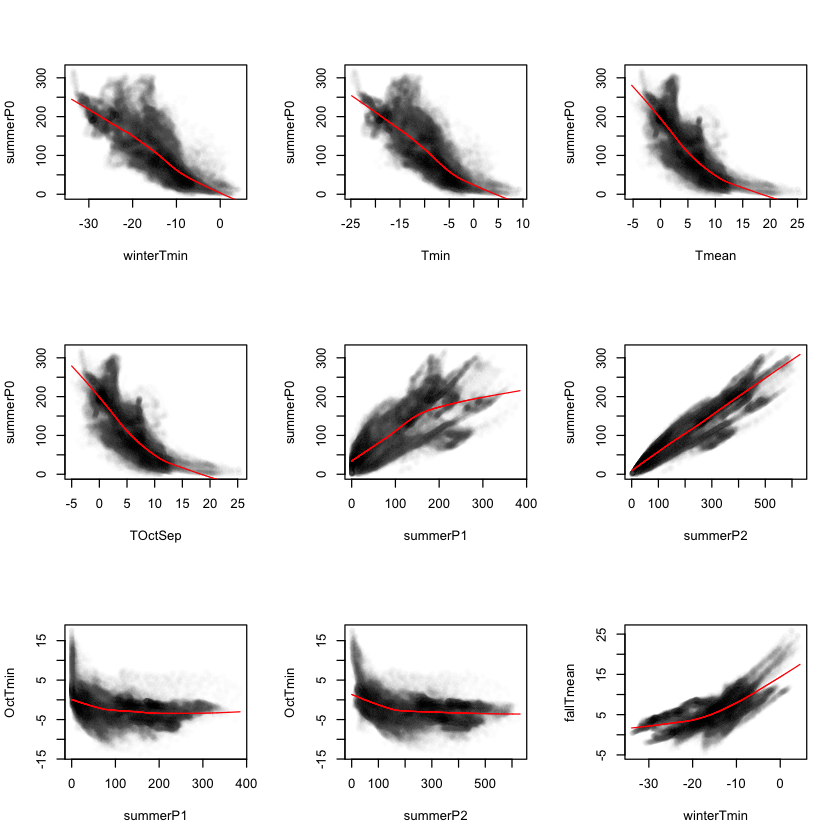

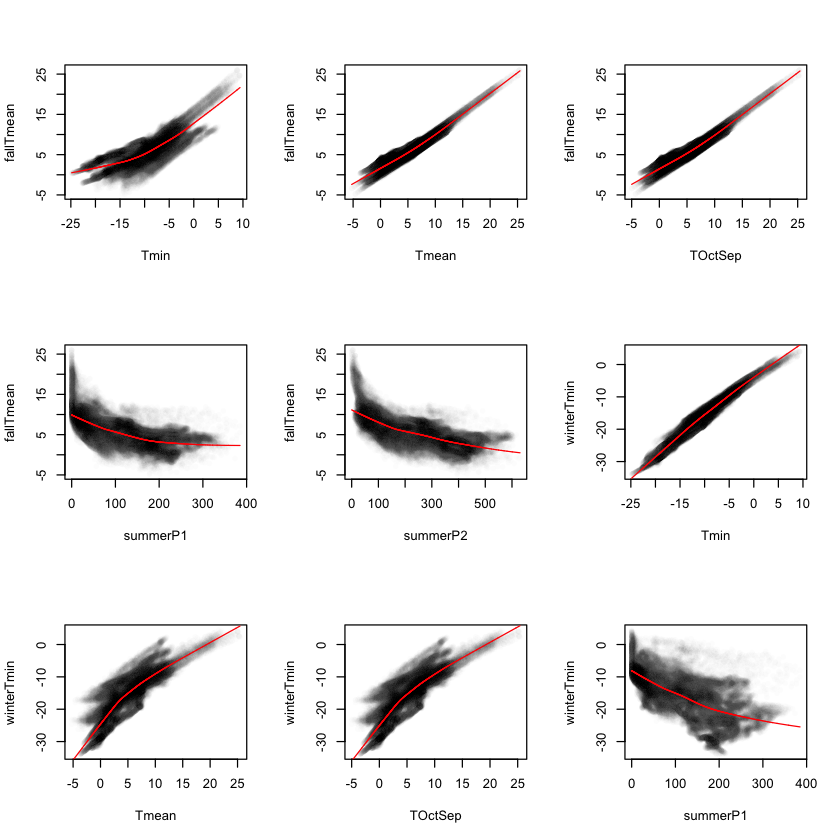

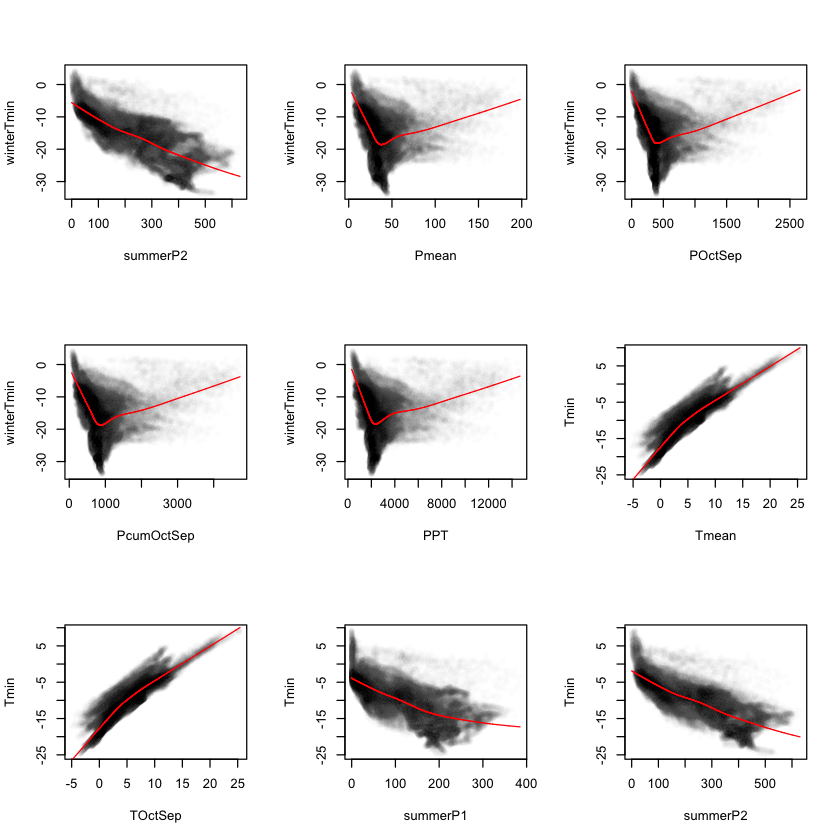

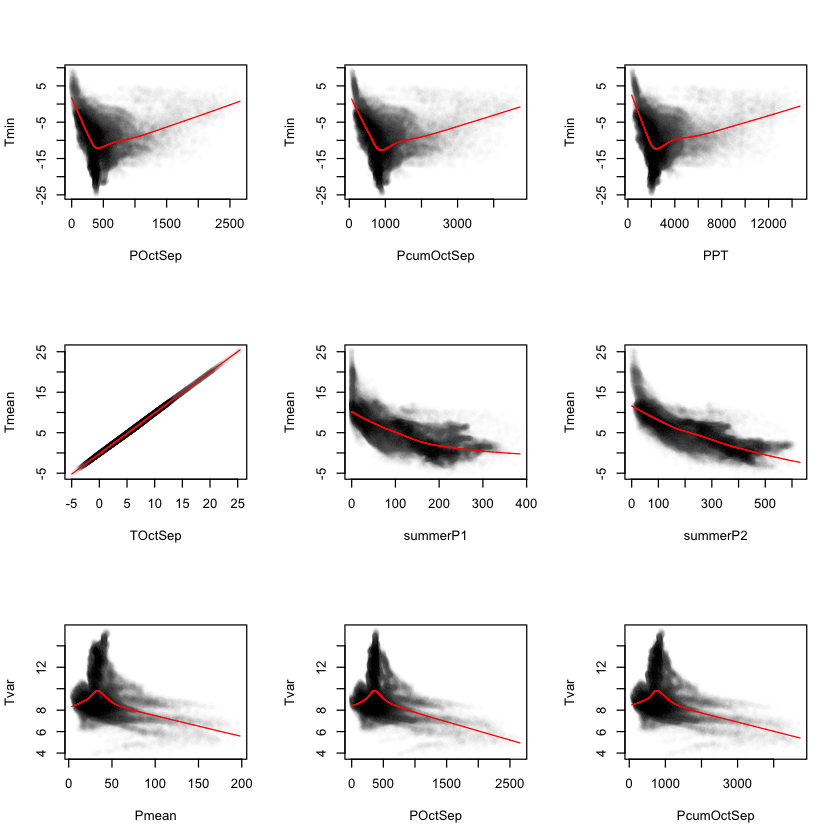

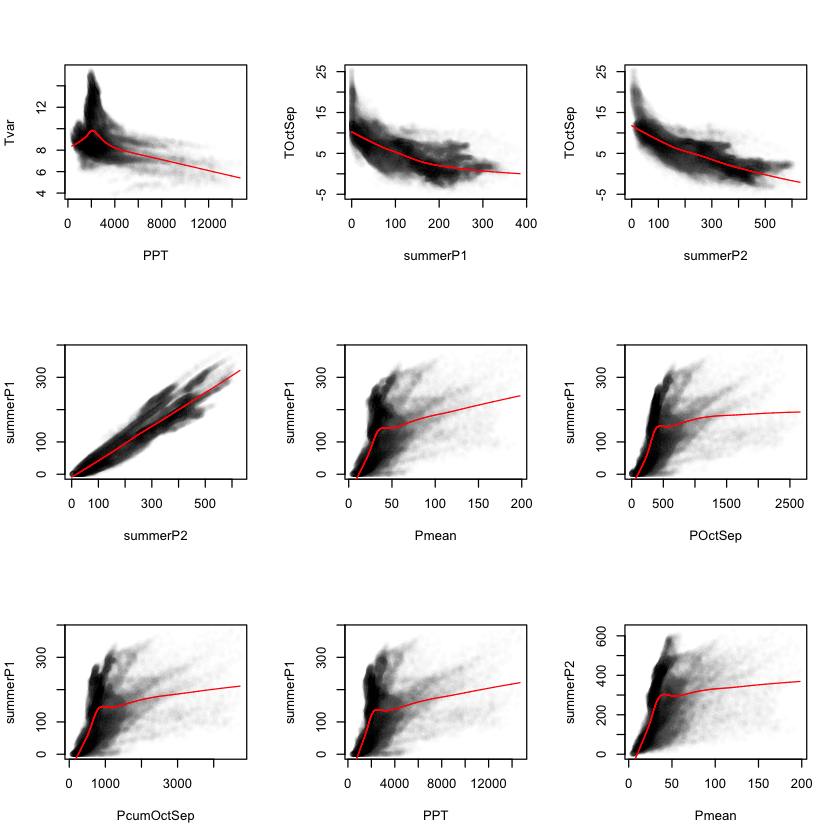

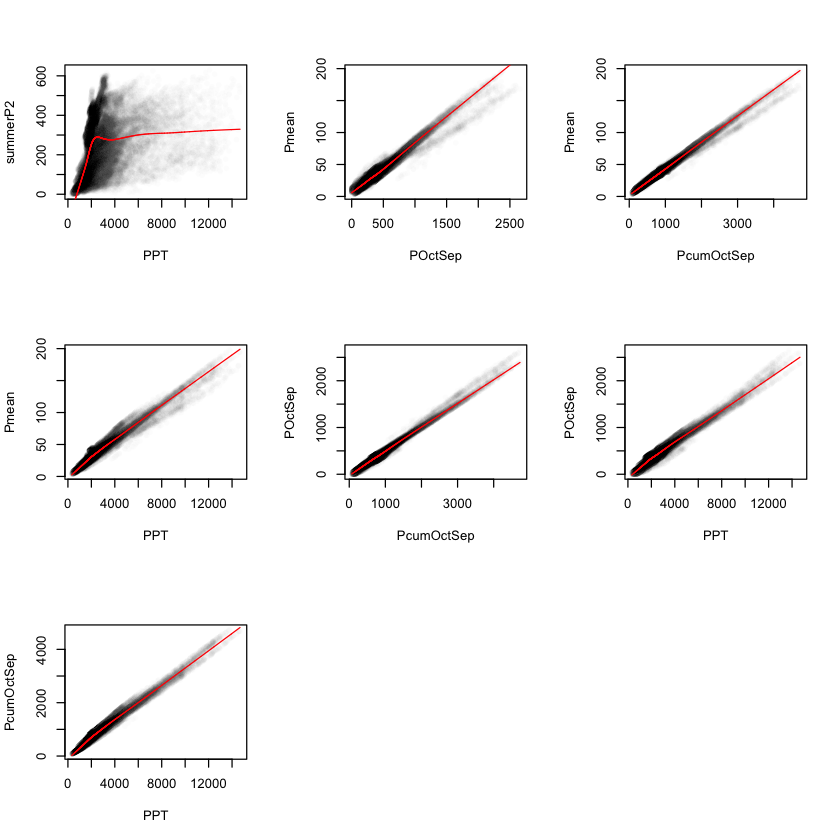

In [22]:
par(mfrow=c(3, 3))
for (i in 1:nrow(most.important)) {
  f1 <- as.character(most.important[i, 1])
  f2 <- as.character(most.important[i, 2])
  has.data <- !(is.na(train[, f1]) | is.na(train[, f2]))
  plot(train[has.data, f1] ~ train[has.data, f2], 
       pch=16, 
       col=rgb(0, 0, 0, 0.01),
       ylab=f1,
       xlab=f2)
  lines(lowess(train[has.data, f1] ~ train[has.data, f2]), col=2)
}

In [30]:
for (i in 1:nrow(most.important)) {
  cat(sprintf("'%s:%s', ", most.important[i, 'f1'], most.important[i, 'f2']))
}

'lon:lat', 'lon:etopo1', 'lon:JanTmin', 'lon:GSP', 'lon:Tvar', 'lon:Pmean', 'lon:POctSep', 'lon:PcumOctSep', 'lon:PPT', 'lat:etopo1', 'lat:density', 'lat:JanTmin', 'lat:MarTmin', 'lat:TMarAug', 'lat:AugTmax', 'lat:PMarAug', 'lat:summerP0', 'lat:OctTmin', 'lat:fallTmean', 'lat:winterTmin', 'lat:Tmin', 'lat:Tmean', 'lat:TOctSep', 'lat:summerP1', 'lat:summerP2', 'etopo1:age', 'etopo1:MarTmin', 'etopo1:summerP0', 'etopo1:winterTmin', 'etopo1:Tmin', 'etopo1:Tmean', 'etopo1:TOctSep', 'etopo1:summerP2', 'density:JanTmin', 'density:MarTmin', 'density:TMarAug', 'density:AugTmax', 'density:PMarAug', 'density:summerP0', 'density:OctTmin', 'density:fallTmean', 'density:winterTmin', 'density:Tmin', 'density:Tmean', 'density:TOctSep', 'density:summerP1', 'density:summerP2', 'JanTmin:MarTmin', 'JanTmin:summerP0', 'JanTmin:OctTmin', 'JanTmin:fallTmean', 'JanTmin:winterTmin', 'JanTmin:Tmin', 'JanTmin:Tmean', 'JanTmin:TOctSep', 'JanTmin:summerP1', 'JanTmin:summerP2', 'JanTmin:Pmean', 'JanTmin:POctSep', 